In [61]:
%matplotlib inline
import cv2
import os
import numpy as np
from copy import deepcopy
import ffmpeg

import sys
#from utils import set_save_files, save_dir, ensure_dir, get_save_files

import matplotlib
from matplotlib.pyplot import imshow, figure, plot, clf

perspective_correction = None
perspective_correction_inv = None
perspective_trapezoid = None
warp_size = None
orig_size = None
left_fit_avg = None
right_fit_avg = None
MIN_DETECTIONS = 8
MAX_DETECTIONS = 10

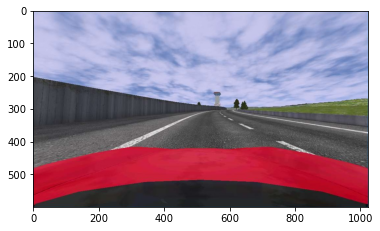

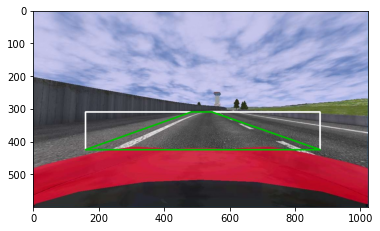

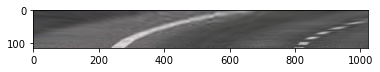

In [62]:
def compute_perspective(width, height, pt1, pt2, pt3, pt4):
    global perspective_trapezoid, perspective_dest

    perspective_trapezoid = [(pt1[0], pt1[1]), (pt2[0], pt2[1]), (pt3[0], pt3[1]), (pt4[0], pt4[1])]
    src = np.float32([pt1, pt2, pt3, pt4])
    # widest side on the trapezoid
    x1 = pt1[0]
    x2 = pt4[0]
    # height of the trapezoid
    y1 = pt1[1]
    y2 = pt2[1]
    h = y1 - y2
    # The destination is a rectangle with the height of the trapezoid and the width of the widest side
    dst = np.float32([[x1, h], [x1, 0], [x2, 0], [x2, h]])
    perspective_dest = [(x1, y1), (x1, y2), (x2, y2), (x2, y1)]

    global perspective_correction, perspective_correction_inv
    global warp_size, orig_size

    perspective_correction = cv2.getPerspectiveTransform(src, dst)
    perspective_correction_inv = cv2.getPerspectiveTransform(dst, src)
    warp_size = (width, h)
    orig_size = (width, height)

def warp(img, filename):
    img_persp = img.copy()

    cv2.line(img_persp, perspective_dest[0], perspective_dest[1], (255, 255, 255), 3)
    cv2.line(img_persp, perspective_dest[1], perspective_dest[2], (255, 255, 255), 3)
    cv2.line(img_persp, perspective_dest[2], perspective_dest[3], (255, 255, 255), 3)
    cv2.line(img_persp, perspective_dest[3], perspective_dest[0], (255, 255, 255), 3)

    cv2.line(img_persp, perspective_trapezoid[0], perspective_trapezoid[1], (0, 192, 0), 3)
    cv2.line(img_persp, perspective_trapezoid[1], perspective_trapezoid[2], (0, 192, 0), 3)
    cv2.line(img_persp, perspective_trapezoid[2], perspective_trapezoid[3], (0, 192, 0), 3)
    cv2.line(img_persp, perspective_trapezoid[3], perspective_trapezoid[0], (0, 192, 0), 3)

    return img_persp, cv2.warpPerspective(img, perspective_correction, warp_size, flags=cv2.INTER_LANCZOS4)

compute_perspective(1024, 600, [160, 425], [484, 310], [546, 310], [877, 425])

filename = r"C:\Users\moyee\Downloads\sd2.jpg"
img_bgr = cv2.imread(filename)
imshow(cv2.cvtColor(img_bgr, cv2.COLOR_RGB2BGR))
figure()
img_persp, img_warped = warp(img_bgr, filename)
imshow(cv2.cvtColor(img_persp, cv2.COLOR_RGB2BGR))
figure()
imshow(cv2.cvtColor(img_warped, cv2.COLOR_RGB2BGR))

C:\Users\moyee\AppData\Local\Temp/ipykernel_688/3206108705.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_hls = cv2.cvtColor(img_warped, cv2.COLOR_BGR2HLS).astype(np.float)


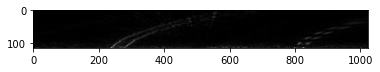

In [63]:
def edge_detection(channel):
    edge_x = cv2.Scharr(channel, cv2.CV_64F, 1, 0)  # Edge detection using the Scharr operator
    edge_x = np.absolute(edge_x)

    return np.uint8(255 * edge_x / np.max(edge_x))

img_hls = cv2.cvtColor(img_warped, cv2.COLOR_BGR2HLS).astype(np.float)
img_edge = edge_detection(img_warped[:, :, 1])
imshow(cv2.cvtColor(img_edge, cv2.COLOR_RGB2BGR))

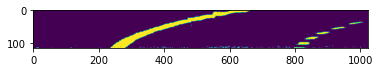

In [64]:
def threshold(channel_threshold, channel_edge, filename):
    # Gradient threshold
    binary = np.zeros_like(channel_edge)
    height = binary.shape[0]

    threshold_up = 15
    threshold_down = 60
    threshold_delta = threshold_down - threshold_up

    for y in range(height):
        binary_line = binary[y, :]
        edge_line = channel_edge[y, :]
        threshold_line = threshold_up + threshold_delta * y / height
        binary_line[edge_line >= threshold_line] = 255

    binary[(channel_threshold >= 140) & (channel_threshold <= 255)] = 255

    binary_threshold = np.zeros_like(channel_threshold)
    binary_threshold[(channel_threshold >= 140) & (channel_threshold <= 255)] = 255

    return binary, binary_threshold

(img_binary_combined, img_binary_solo) = threshold(img_hls[:, :, 1], img_edge, filename)

imshow(img_binary_combined)

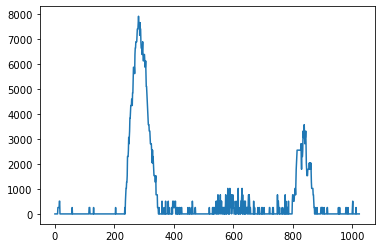

In [65]:
def histogram(img):
    partial_img = img[img.shape[0] * 2 // 3:, :]  # Select the bottom part (one third of the image)
    hist = np.sum(partial_img, axis=0)

    plot(hist)

    return hist

hist = histogram(img_binary_combined)

281
838
7905
3570


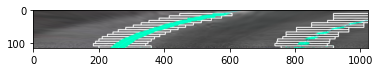

In [66]:
class HistLanes:
    def __init__(self, x_left, x_right, left_confidence, right_confidence):
        self.x_left = x_left
        self.x_right = x_right
        self.left_confidence = left_confidence
        self.right_confidence = right_confidence

def lanes_full_histogram(histogram):
    size = len(histogram)
    max_index_left = np.argmax(histogram[0:size // 2])
    max_index_right = np.argmax(histogram[size // 2:]) + size // 2

    return HistLanes(max_index_left, max_index_right, histogram[max_index_left], histogram[max_index_right])

def moving_average(prev_average, new_value, beta):
    return beta * prev_average + (1 - beta) * new_value if prev_average is not None else new_value

# Single lane line
class Line:
    lane_indexes = None
    # pixel positions
    x = None
    y = None

    # Fit a second order polynomial to each
    fit = None
    # Plotting parameters
    fitx = None

    # Histogram
    hist_x = None


# Data collected during the sliding windows phase
class SlideWindow:
    left = Line()
    right = Line()
    hist = None

    left_avg = None
    right_avg = None

    ploty = None

    def __init__(self, hist, left_lane_indexes, right_lane_indexes, non_zero_x, non_zero_y):
        self.left.lane_indexes = np.concatenate(left_lane_indexes)
        self.right.lane_indexes = np.concatenate(right_lane_indexes)
        self.left.hist_x = hist.x_left
        self.right.hist_x = hist.x_right
        # Extract left and right positions
        self.left.x = non_zero_x[self.left.lane_indexes]
        self.left.y = non_zero_y[self.left.lane_indexes]
        self.right.x = non_zero_x[self.right.lane_indexes]
        self.right.y = non_zero_y[self.right.lane_indexes]

    def plot_lines(self, img, color_left=(0, 255, 255), color_right=(0, 255, 255)):
        left = []
        right = []
        for i in range(0, len(self.ploty)):
            left.append((self.left.fitx[i], self.ploty[i]))
            right.append((self.right.fitx[i], self.ploty[i]))

        cv2.polylines(img, np.int32([left]), False, color_left)
        cv2.polylines(img, np.int32([right]), False, color_right)

        return img


def fit_slide_window(binary_warped, hist, left_lane_indexes, right_lane_indexes, non_zero_x, non_zero_y):
    sw = SlideWindow(hist, left_lane_indexes, right_lane_indexes, non_zero_x, non_zero_y)

    # y coordinates
    sw.ploty = np.array([float(x) for x in range(binary_warped.shape[0])])

    if len(sw.left.y) == 0:
        return False, sw

    # Fit a second order polynomial to approximate the points
    left_fit = np.polynomial.polynomial.polyfit(sw.left.y, sw.left.x, 2)
    right_fit = np.polynomial.polynomial.polyfit(sw.right.y, sw.right.x, 2)

    global left_fit_avg, right_fit_avg

    left_fit_avg = moving_average(left_fit_avg, left_fit, 0.92)
    right_fit_avg = moving_average(right_fit_avg, right_fit, 0.92)

    # Generate list of x and y values, using the terms of the polynomial
    # x = Ay^2 + By + C;
    sw.left.fitx = left_fit_avg[2] * sw.ploty ** 2 + left_fit_avg[1] * sw.ploty + left_fit_avg[0]
    sw.right.fitx = right_fit_avg[2] * sw.ploty ** 2 + right_fit_avg[1] * sw.ploty + right_fit_avg[0]

    return True, sw

def slide_window(img, binary_warped, hist, num_windows):
    img_height = binary_warped.shape[0]
    window_height = np.int64(img_height / num_windows)
    # Indices (e.g. coordinates) of the pixels that are not zero
    non_zero = binary_warped.nonzero()
    non_zero_y = np.array(non_zero[0])
    non_zero_x = np.array(non_zero[1])
    # Current positions, to be updated while sliding the window; we start with the ones identified with the histogram
    left_x = hist.x_left
    right_x = hist.x_right
    margin = 80
    # Set minimum number of pixels found to recenter window
    min_pixels = 25
    left_lane_indexes = []
    right_lane_indexes = []

    out_img = img.copy()

    for idx_window in range(num_windows):
        # X range where we expect the left lane to land
        win_x_left_min = left_x - margin
        win_x_left_max = left_x + margin
        # X range where we expect the right lane to land
        win_x_right_min = right_x - margin
        win_x_right_max = right_x + margin
        # Y range that we are analyzing
        win_y_top = img_height - idx_window * window_height
        win_y_bottom = win_y_top - window_height

        # Show the windows
        cv2.rectangle(out_img, (win_x_left_min, win_y_bottom), (win_x_left_max, win_y_top), (255, 255, 255), 2)
        cv2.rectangle(out_img, (win_x_right_min, win_y_bottom), (win_x_right_max, win_y_top), (255, 255, 255), 2)

        # Non zero pixels in x and y
        non_zero_left = ((non_zero_y >= win_y_bottom) & (non_zero_y < win_y_top) & (non_zero_x >= win_x_left_min) & (
                non_zero_x < win_x_left_max)).nonzero()[0]
        non_zero_right = ((non_zero_y >= win_y_bottom) & (non_zero_y < win_y_top) & (non_zero_x >= win_x_right_min) & (
                non_zero_x < win_x_right_max)).nonzero()[0]

        left_lane_indexes.append(non_zero_left)
        right_lane_indexes.append(non_zero_right)
        # If you found > min_pixels pixels, recenter next window on the mean position
        if len(non_zero_left) > min_pixels:
            left_x = np.int64(np.mean(non_zero_x[non_zero_left]))

        if len(non_zero_right) > min_pixels:
            right_x = np.int64(np.mean(non_zero_x[non_zero_right]))

    valid, sw = fit_slide_window(binary_warped, hist, left_lane_indexes, right_lane_indexes, non_zero_x, non_zero_y)

    if valid :
        out_img[non_zero_y[sw.left.lane_indexes], non_zero_x[sw.left.lane_indexes]] = [0, 255, 192]
        out_img[non_zero_y[sw.right.lane_indexes], non_zero_x[sw.right.lane_indexes]] = [0, 255, 192]
        img_plot = sw.plot_lines(out_img)

        imshow(img_plot)

    return valid, sw

lanes = lanes_full_histogram(hist)
print(lanes.x_left)
print(lanes.x_right)
print(lanes.left_confidence)
print(lanes.right_confidence)

ret, sw = slide_window(img_warped, img_binary_combined, lanes, 15)

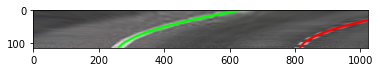

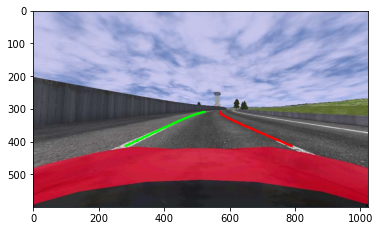

In [67]:
def show_lanes(sw, img_warped, img_orig):
    img = img_warped.copy()

    if sw.left:
        fitx_points_warped = np.float32([np.transpose(np.vstack([sw.left.fitx, sw.ploty]))])
        fitx_points = cv2.perspectiveTransform(fitx_points_warped, perspective_correction_inv)
        left_line_warped = np.int_(fitx_points_warped[0])
        left_line = np.int_(fitx_points[0])
        n = len(left_line)

        for i in range(n - 1):
            cv2.line(img_orig, (left_line[i][0], left_line[i][1]), (left_line[i + 1][0], left_line[i + 1][1]),
                     (0, 255, 0), 5)
            cv2.line(img, (left_line_warped[i][0], left_line_warped[i][1]),
                     (left_line_warped[i + 1][0], left_line_warped[i + 1][1]), (0, 255, 0), 5)

    if sw.right:
        fitx_points_warped = np.float32([np.transpose(np.vstack([sw.right.fitx, sw.ploty]))])
        fitx_points = cv2.perspectiveTransform(fitx_points_warped, perspective_correction_inv)
        right_line_warped = np.int_(fitx_points_warped[0])
        right_line = np.int_(fitx_points[0])

        for i in range(len(right_line) - 1):
            cv2.line(img_orig, (right_line[i][0], right_line[i][1]), (right_line[i + 1][0], right_line[i + 1][1]),
                     (0, 0, 255), 5)
            cv2.line(img, (right_line_warped[i][0], right_line_warped[i][1]),
                     (right_line_warped[i + 1][0], right_line_warped[i + 1][1]), (0, 0, 255), 5)

    return img, img_orig

left_lanes = deepcopy(sw.left)
right_lanes = deepcopy(sw.right)

img_lane, img_lane_orig = show_lanes(sw, img_warped, img_bgr)

imshow(cv2.cvtColor(img_lane, cv2.COLOR_RGB2BGR))
figure()
imshow(cv2.cvtColor(img_lane_orig, cv2.COLOR_RGB2BGR))

In [68]:
def reset():
    global left_fit_avg, right_fit_avg

    left_fit_avg = None
    right_fit_avg = None

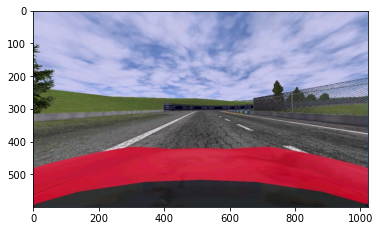

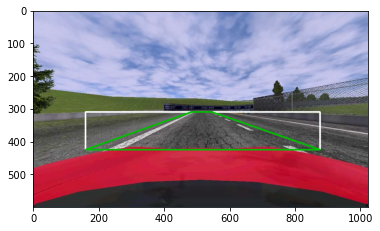

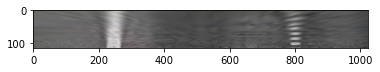

In [69]:
filename = r"C:\Users\moyee\Downloads\sd1.jpg"
img_bgr = cv2.imread(filename)
imshow(cv2.cvtColor(img_bgr, cv2.COLOR_RGB2BGR))
figure()
img_persp, img_warped = warp(img_bgr, filename)
imshow(cv2.cvtColor(img_persp, cv2.COLOR_RGB2BGR))
figure()
imshow(cv2.cvtColor(img_warped, cv2.COLOR_RGB2BGR))

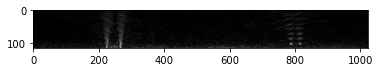

In [70]:
img_hls = cv2.cvtColor(img_warped, cv2.COLOR_BGR2HLS).astype(float)
img_edge = edge_detection(img_warped[:, :, 1])
imshow(cv2.cvtColor(img_edge, cv2.COLOR_RGB2BGR))

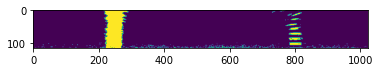

In [71]:
(img_binary_combined, img_binary_solo) = threshold(img_hls[:, :, 1], img_edge, filename)

imshow(img_binary_combined)

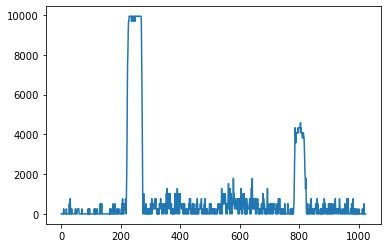

In [72]:
hist = histogram(img_binary_combined)

228
804
9945
4590


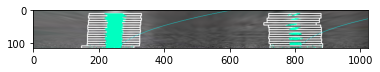

In [73]:
lanes = lanes_full_histogram(hist)
print(lanes.x_left)
print(lanes.x_right)
print(lanes.left_confidence)
print(lanes.right_confidence)

ret, sw = slide_window(img_warped, img_binary_combined, lanes, 15)

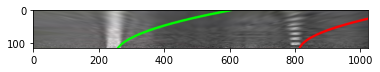

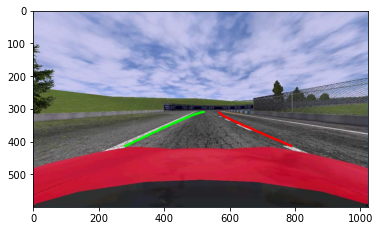

In [74]:
left_lanes = deepcopy(sw.left)
right_lanes = deepcopy(sw.right)

img_lane, img_lane_orig = show_lanes(sw, img_warped, img_bgr)

imshow(cv2.cvtColor(img_lane, cv2.COLOR_RGB2BGR))
figure()
imshow(cv2.cvtColor(img_lane_orig, cv2.COLOR_RGB2BGR))

In [75]:
reset()

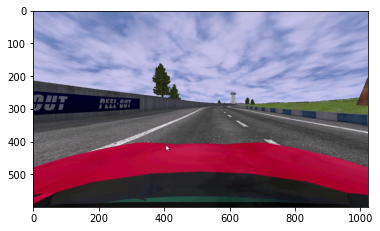

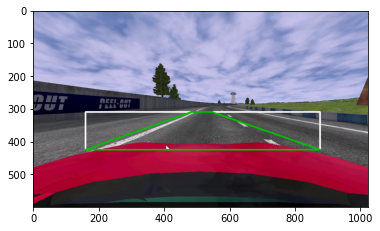

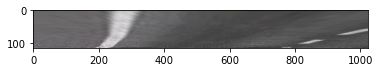

In [76]:
filename = r"C:\Users\moyee\Downloads\sd3.jpg"
img_bgr = cv2.imread(filename)
imshow(cv2.cvtColor(img_bgr, cv2.COLOR_RGB2BGR))
figure()
img_persp, img_warped = warp(img_bgr, filename)
imshow(cv2.cvtColor(img_persp, cv2.COLOR_RGB2BGR))
figure()
imshow(cv2.cvtColor(img_warped, cv2.COLOR_RGB2BGR))

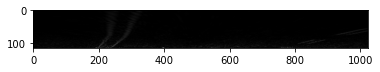

In [77]:
img_hls = cv2.cvtColor(img_warped, cv2.COLOR_BGR2HLS).astype(float)
img_edge = edge_detection(img_warped[:, :, 1])
imshow(cv2.cvtColor(img_edge, cv2.COLOR_RGB2BGR))

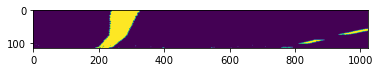

In [78]:
(img_binary_combined, img_binary_solo) = threshold(img_hls[:, :, 1], img_edge, filename)

imshow(img_binary_combined)

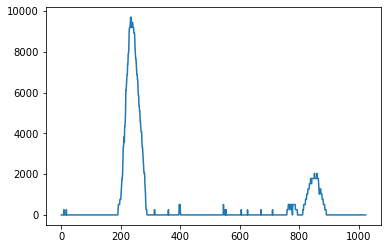

In [79]:
hist = histogram(img_binary_combined)

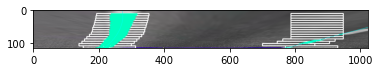

In [80]:
lanes = lanes_full_histogram(hist)
ret, sw = slide_window(img_warped, img_binary_combined, lanes, 15)

In [81]:
left_lanes = deepcopy(sw.left)
right_lanes = deepcopy(sw.right)

img_lane, img_lane_orig = show_lanes(sw, img_warped, img_bgr)

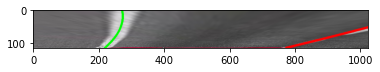

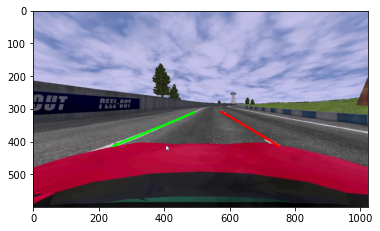

In [82]:
imshow(cv2.cvtColor(img_lane, cv2.COLOR_RGB2BGR))
figure()
imshow(cv2.cvtColor(img_lane_orig, cv2.COLOR_RGB2BGR))

In [94]:
def lanes_full_histogram(histogram):
    size = len(histogram)
    max_index_left = np.argmax(histogram[0:size // 2])
    max_index_right = np.argmax(histogram[size // 2:]) + size // 2

    return HistLanes(max_index_left, max_index_right, histogram[max_index_left], histogram[max_index_right])


def lanes_partial_histogram(histogram, left_lanes, right_lanes, tolerance):
    max_index_left = partial_lane(histogram, left_lanes, tolerance)
    max_index_right = partial_lane(histogram, right_lanes, tolerance)

    return HistLanes(max_index_left, max_index_right, histogram[max_index_left], histogram[max_index_right])

def avg_x(hist_lanes):
    return sum([lane.hist_x for lane in hist_lanes]) // len(hist_lanes)

def partial_lane(histogram, lanes_previous_frames, tolerance):
    lane_avg = avg_x(lanes_previous_frames)
    lane_min = max(lane_avg - tolerance, 0)
    lane_max = min(lane_avg + tolerance, len(histogram))

    return np.argmax(histogram[lane_min:lane_max]) + lane_min


def detect_lanes(img_bgr, filename, left_lanes, right_lanes):
    img_persp, img_warped = warp(img_bgr, filename)
    img_hls = cv2.cvtColor(img_warped, cv2.COLOR_BGR2HLS).astype(float)
    img_edge = edge_detection(img_warped[:, :, 1])
    (img_binary_combined, img_binary_solo) = threshold(img_hls[:, :, 1], img_edge, filename)
    hist = histogram(img_binary_combined)
    #histogram(img_binary_solo)

    if (len(left_lanes) > MIN_DETECTIONS):
        lanes = lanes_partial_histogram(hist, left_lanes, right_lanes, 30)
    else:
        lanes = lanes_full_histogram(hist)

    ret, sw = slide_window(img_warped, img_binary_combined, lanes, 15)

    if ret:
        left_lanes.append(deepcopy(sw.left))
        right_lanes.append(deepcopy(sw.right))
    else:
        # In case of problems, use the previous detection
        sw.left = left_lanes[len(left_lanes) - 1]
        sw.right = right_lanes[len(right_lanes) - 1]

        left_lanes.append(sw.left)
        right_lanes.append(sw.right)

    img_lane, img_lane_orig = show_lanes(sw, img_warped, img_bgr)

    return img_lane_orig

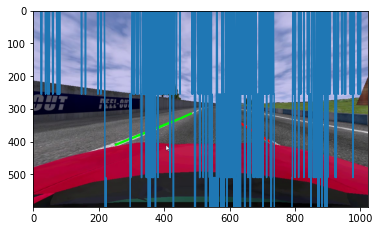

In [110]:
filename = r"C:\Users\moyee\Downloads\sd3.jpg"
reset()
img_bgr = cv2.imread(filename)
imshow(cv2.cvtColor(detect_lanes(img_bgr, "sd3.jpg", [], []), cv2.COLOR_RGB2BGR))

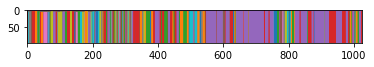

In [112]:
cap = cv2.VideoCapture(r"C:\Users\moyee\Downloads\video-sd.mp4")
writer = cv2.VideoWriter('video-sd-out.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 10, (int(cap.get(3)),int(cap.get(4))))#(1024, 600)

n = 0
left_lanes = []
right_lanes = []

compute_perspective(1024, 600, [140, 415], [445, 315], [596, 315], [867, 415])
reset()

while True:
    ret, frame = cap.read()
    if not (ret):
        break

    frame = detect_lanes(frame, "frame_" + str(n) + ".jpg", left_lanes, right_lanes)
    writer.write(frame)#cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    if (len(left_lanes) > MAX_DETECTIONS):
        left_lanes = left_lanes[1:]
        right_lanes = right_lanes[1:]

writer.release()
cap.release()